<a href="https://colab.research.google.com/github/Devansh4724/Pulpnet/blob/main/Week1-2/240340_DevanshChaturvedi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the necessary Libraries and Packages

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
import spacy
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Reading the CSV file

In [29]:
df = pd.read_csv("/content/movie.csv")

# Exploratory Data Analysis

i) Basic Structure of the data

In [30]:
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


ii) Checking for and dropping the duplicate entries

In [31]:
for i in df['text'].duplicated():
  if (i==True):
    print("Duplicate value exists")
    break

df=df.drop_duplicates()
print(f'After dropping duplicates, new data shape: {df.shape}')

Duplicate value exists
After dropping duplicates, new data shape: (39723, 2)


iii) Dropping missing entries

In [32]:
df=df.dropna(axis=0)
print(f'After dropping missing entries, new data shape: {df.shape}')

After dropping missing entries, new data shape: (39723, 2)


iv) Checking inconsistency in data

In [33]:
for i in df['label']:
  if (i!=0 and i!=1):
    print(i)

v) Distribution between positive and negative reviews

In [34]:
df['label'].value_counts()

,count
label,
1,19908
0,19815


vi) Graph of length of reviews vs the sentiment

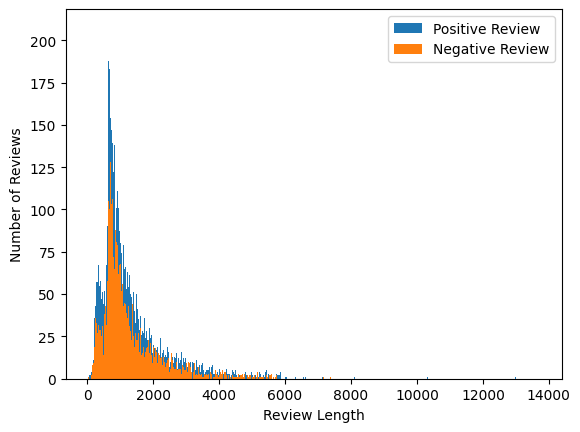

In [35]:
lengths=[]
lengthsp=[]
lengthsn=[]
label=[]
for i in df['text']:
  lengths.append(len(i))
for i in df['label']:
  label.append(i)
j=0
for j in range(len(label)):
  if(label[j]==0):
    lengthsn.append(lengths[j])
  else:
    lengthsp.append(lengths[j])

plt.hist(lengthsp,bins=2000)
plt.hist(lengthsn,bins=2000)
plt.legend(["Positive Review","Negative Review"])
plt.xlabel("Review Length")
plt.ylabel("Number of Reviews")
plt.show()

# Data Pre-Processing

Removing non-alphabetic characters and non-numerals, conversion to lowercase and applying Tokenization

In [36]:
index1=0
tokenizer = RegexpTokenizer(r'\w+')
for review in df['text']:
  review = review.lower()
  review = re.sub(r'[^\w\s]', '', review)
  review = re.sub(r'\d+', '', review)
  df['text'].iloc[index1]=review
  index1+=1
tokenizer = RegexpTokenizer(r'\w+')
df['text'] = df['text'].apply(tokenizer.tokenize)

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['text'].iloc[index1]=review
<ipython-input-36-c0dec2f7ab1a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'].iloc[index1]=review
<ipython-input-36-c0dec2f7ab1a>:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are settin

Applying Stemming

In [37]:
stemmer = PorterStemmer()
df['text'] = df['text'].apply(lambda words: [stemmer.stem(word) for word in words])
df['text'] = df['text'].apply(lambda words: ' '.join(words))

Applying Lemmatisation

In [38]:
nlp = spacy.load("en_core_web_sm",disable=["ner", "parser"])
reviews = df['text'].to_list()
lemmatized_reviews = []
for review in tqdm(nlp.pipe(reviews,batch_size=1000),total=len(reviews)):
  l1=[]
  for word in review:
    l1.append(word.lemma_)
  lemmatized_reviews.append(" ".join(l1))
df['text'] = lemmatized_reviews

100%|██████████| 39723/39723 [09:22<00:00, 70.63it/s] 


Performing Train Test Split

In [39]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(df.iloc[:,0],df.iloc[:,1],train_size=0.8,random_state=42)

# Feature Extraction

Creating Embeddings

In [40]:
tfidf = TfidfVectorizer()
train_tfidf_matrix = tfidf.fit_transform(Xtrain)
test_tfidf_matrix = tfidf.transform(Xtest)

In [41]:
cv = CountVectorizer(binary=True)
train_cv_matrix = cv.fit_transform(Xtrain)
test_cv_matrix = cv.transform(Xtest)

# Model Selection, Training and Evaluation

In [42]:
def round_off_values(prediction):
  int_predictions = []
  for i in prediction:
    if (i>=0.5):
      int_predictions.append(1)
    else:
      int_predictions.append(0)
  return int_predictions

def cm_plot(Ytest,predictions):
  Confm = confusion_matrix(Ytest,predictions)
  display = ConfusionMatrixDisplay(Confm)
  display.plot()
  plt.title("Confusion Matrix - Sentiment Classifier for Movie Reviews")
  plt.show()

# i) Neural Network

a) Using TF-IDF Vectorizer

In [43]:
model1 = Sequential()
model1.add(Dense(16,activation="relu"))
model1.add(Dropout(0.5))
model1.add(Dense(8,activation="relu"))
model1.add(Dropout(0.3))
model1.add(Dense(1,activation="sigmoid"))

In [44]:
model1.compile(optimizer="adam",loss="mean_squared_error",metrics=['accuracy'])

In [45]:
history11=model1.fit(train_tfidf_matrix,Ytrain,epochs=20,batch_size=3000)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5758 - loss: 0.2489
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.7106 - loss: 0.2409
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7386 - loss: 0.2302
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7654 - loss: 0.2183
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7796 - loss: 0.2060
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7898 - loss: 0.1941
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8164 - loss: 0.1807
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8344 - loss: 0.1689
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8442 - loss: 0.1587
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8571 - loss: 0.1480
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8731 - loss: 0.1368
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8806 - lo

In [46]:
predictions11 = model1.predict(test_tfidf_matrix)
predictions11 = round_off_values(predictions11)
f1_11 = f1_score(Ytest,predictions11)
roc_auc11 = roc_auc_score(Ytest,predictions11)
print(f'Accuracy:{model1.evaluate(test_tfidf_matrix,Ytest)[1]*100}%\nF1 score:{f1_11}\nROC AUC Score:{roc_auc11}')

249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - accuracy: 0.8947 - loss: 0.0877
Accuracy:89.35179114341736%
F1 score:0.89266683582847
ROC AUC Score:0.8935003859848037


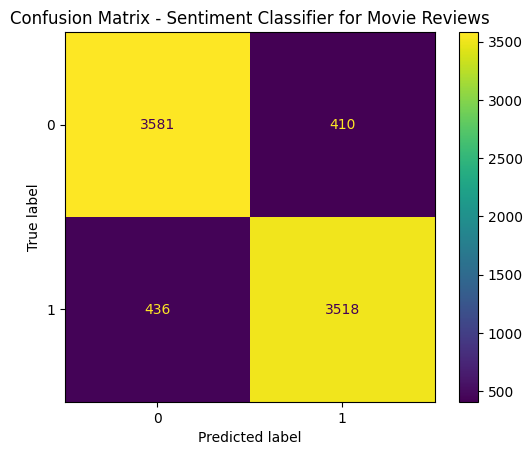

In [47]:
cm_plot(Ytest,predictions11)

b) Using Count Vectorizer

In [49]:
model1 = Sequential()
model1.add(Dense(16,activation="relu"))
model1.add(Dropout(0.5))
model1.add(Dense(8,activation="relu"))
model1.add(Dropout(0.3))
model1.add(Dense(1,activation="sigmoid"))

In [50]:
model1.compile(optimizer="adam",loss="mean_squared_error",metrics=['accuracy'])

In [51]:
history12 = model1.fit(train_cv_matrix,Ytrain,epochs=20,batch_size=3000)

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5284 - loss: 0.2433
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6611 - loss: 0.2086
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7842 - loss: 0.1889
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8477 - loss: 0.1750
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8817 - loss: 0.1656
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8978 - loss: 0.1560
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9194 - loss: 0.1493
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9243 - loss: 0.1423
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9332 - loss: 0.1339
Epoch 10/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9378 - loss: 0.1270
Epoch 11/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9380 - loss: 0.1192
Epoch 12/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9432 - lo

In [52]:
predictions12 = model1.predict(test_cv_matrix)
predictions12 = round_off_values(predictions12)
f1_12 = f1_score(Ytest,predictions12)
roc_auc12 = roc_auc_score(Ytest,predictions12)
print(f'Accuracy:{model1.evaluate(test_cv_matrix,Ytest)[1]*100}%\nF1 score:{f1_12}\nROC AUC Score:{roc_auc12}')

249/249 ━━━━━━━━━━━━━━━━━━━━ 29s 114ms/step
249/249 ━━━━━━━━━━━━━━━━━━━━ 36s 143ms/step - accuracy: 0.8841 - loss: 0.1013
Accuracy:88.31969499588013%
F1 score:0.8798549974106681
ROC AUC Score:0.883086590757378


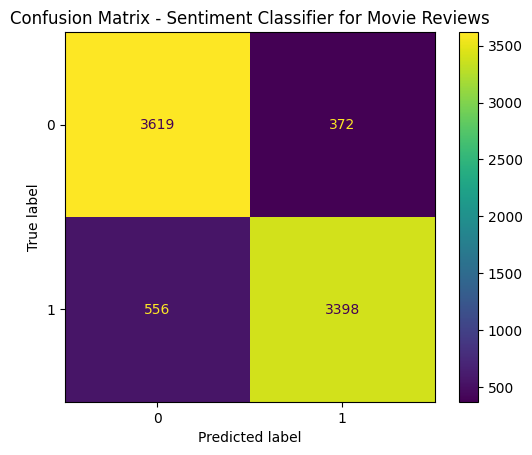

In [66]:
cm_plot(Ytest,predictions12)

# ii) Bernoulli Naive Bayes

a) Using TF-IDF Vectorizer

In [53]:
model2 = BernoulliNB()
model2.fit(train_tfidf_matrix,Ytrain)
predictions21 = model2.predict(test_tfidf_matrix)
predictions21 = round_off_values(predictions21)
f1_21 = f1_score(Ytest,predictions21)
roc_auc21 = roc_auc_score(Ytest,predictions21)
print(f'Accuracy:{accuracy_score(Ytest,predictions21)*100}%\nF1 score:{f1_21}\nROC AUC Score:{roc_auc21}')

Accuracy:84.93392070484582%
F1 score:0.8456877658888745
ROC AUC Score:0.8492474278558219


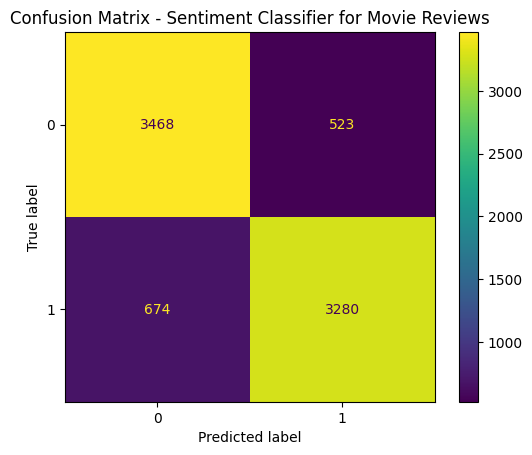

In [54]:
cm_plot(Ytest,predictions21)

b) Using Count Vectorizer

In [55]:
model2 = BernoulliNB()
model2.fit(train_cv_matrix,Ytrain)
predictions22 = model2.predict(test_cv_matrix)
predictions22 = round_off_values(predictions22)
f1_22 = f1_score(Ytest,predictions22)
roc_auc22 = roc_auc_score(Ytest,predictions22)
print(f'Accuracy:{accuracy_score(Ytest,predictions22)*100}%\nF1 score:{f1_22}\nROC AUC Score:{roc_auc22}')

Accuracy:84.93392070484582%
F1 score:0.8456877658888745
ROC AUC Score:0.8492474278558219


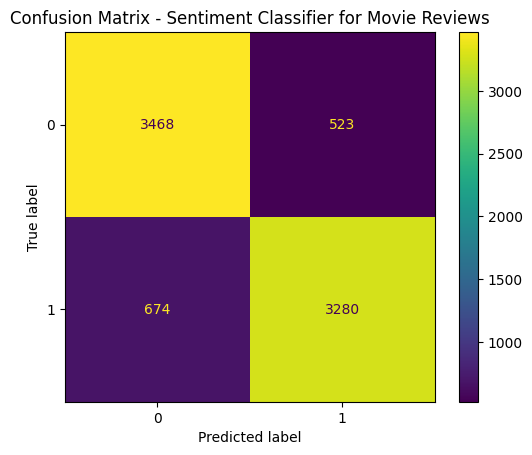

In [56]:
cm_plot(Ytest,predictions22)

# iii) Logistic Regression

a) Using TF-IDF Vectorizer

In [57]:
lr = LogisticRegression()
lr.fit(train_tfidf_matrix,Ytrain)
predictions31 = lr.predict(test_tfidf_matrix)
predictions31 = round_off_values(predictions31)
f1_31 = f1_score(Ytest,predictions31)
roc_auc31 = roc_auc_score(Ytest,predictions31)
print(f'Accuracy:{accuracy_score(Ytest,predictions31)*100}%\nF1 score:{f1_31}\nROC AUC Score:{roc_auc31}')

Accuracy:88.81057268722466%
F1 score:0.8888611076384548
ROC AUC Score:0.8881566415177701


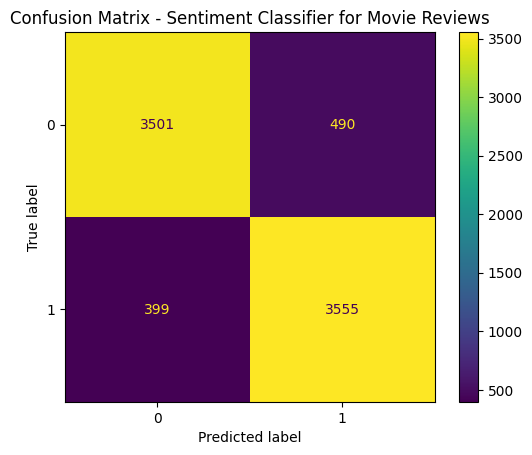

In [58]:
cm_plot(Ytest,predictions31)

b) Using Count Vectorizer



In [59]:
lr = LogisticRegression()
lr.fit(train_cv_matrix,Ytrain)
predictions32 = lr.predict(test_cv_matrix)
predictions32 = round_off_values(predictions32)
f1_32 = f1_score(Ytest,predictions32)
roc_auc32 = roc_auc_score(Ytest,predictions32)
print(f'Accuracy:{accuracy_score(Ytest,predictions32)*100}%\nF1 score:{f1_32}\nROC AUC Score:{roc_auc32}')

Accuracy:87.07363121460038%
F1 score:0.8715125735018141
ROC AUC Score:0.8707833330608437


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


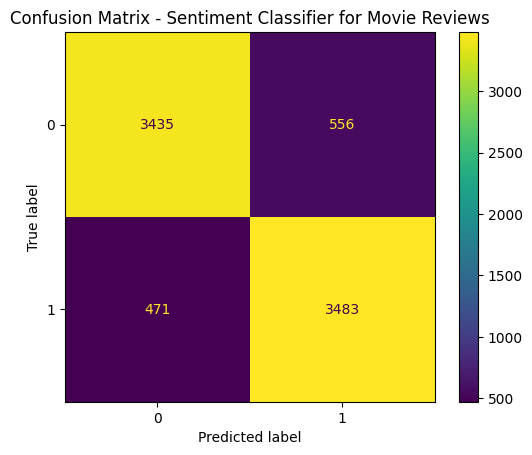

In [60]:
cm_plot(Ytest,predictions32)

# iv) Random Forest Classifier

a) Using TF-IDF Vectorizer

In [62]:
rf = RandomForestClassifier()
rf.fit(train_tfidf_matrix,Ytrain)
predictions41 = lr.predict(test_tfidf_matrix)
predictions41 = round_off_values(predictions41)
f1_41 = f1_score(Ytest,predictions41)
roc_auc41 = roc_auc_score(Ytest,predictions41)
print(f'Accuracy:{accuracy_score(Ytest,predictions41)*100}%\nF1 score:{f1_41}\nROC AUC Score:{roc_auc41}')

Accuracy:82.59282567652612%
F1 score:0.8440987487318228
ROC AUC Score:0.8264889628370966


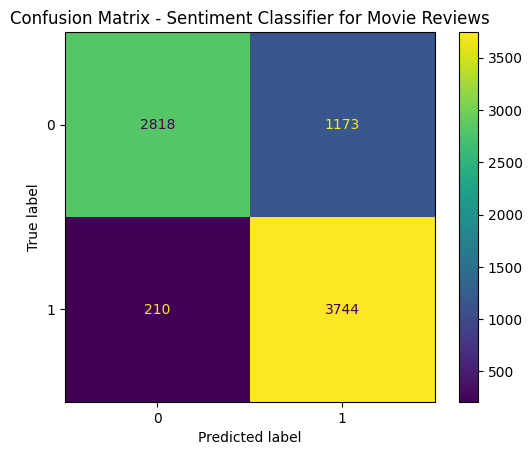

In [63]:
cm_plot(Ytest,predictions41)

b) Using Count Vectorizer

In [64]:
rf = RandomForestClassifier()
rf.fit(train_cv_matrix,Ytrain)
predictions42 = lr.predict(test_cv_matrix)
predictions42 = round_off_values(predictions42)
f1_42 = f1_score(Ytest,predictions42)
roc_auc42 = roc_auc_score(Ytest,predictions42)
print(f'Accuracy:{accuracy_score(Ytest,predictions42)*100}%\nF1 score:{f1_42}\nROC AUC Score:{roc_auc42}')

Accuracy:87.07363121460038%
F1 score:0.8715125735018141
ROC AUC Score:0.8707833330608437


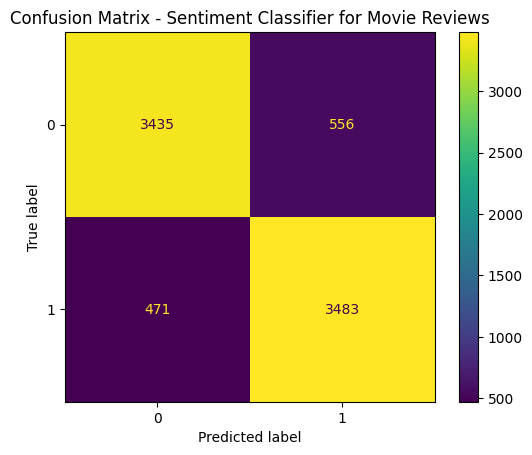

In [65]:
cm_plot(Ytest,predictions42)

# v) SVM (Support Vector Machine)

a) Using TF-IDF Vectorizer

In [ ]:
svc = SVC(kernel="linear")
svc.fit(train_tfidf_matrix,Ytrain)
predictions51 = lr.predict(test_tfidf_matrix)
predictions51 = round_off_values(predictions51)
f1_51 = f1_score(Ytest,predictions51)
roc_auc51 = roc_auc_score(Ytest,predictions51)
print(f'Accuracy:{accuracy_score(Ytest,predictions51)*100}%\nF1 score:{f1_51}\nROC AUC Score:{roc_auc51}')

In [ ]:
cm_plot(Ytest,predictions51)

b) Using Count Vectorizer

In [ ]:
svc = SVC(kernel="linear")
svc.fit(train_cv_matrix,Ytrain)
predictions52 = lr.predict(test_cv_matrix)
predictions52 = round_off_values(predictions52)
f1_52 = f1_score(Ytest,predictions52)
roc_auc52 = roc_auc_score(Ytest,predictions52)
print(f'Accuracy:{accuracy_score(Ytest,predictions52)*100}%\nF1 score:{f1_52}\nROC AUC Score:{roc_auc52}')

In [ ]:
cm_plot(Ytest,predictions52)